In [1]:
from fourlang.text_to_4lang import TextTo4lang
from fourlang.lexicon import Lexicon
from graphviz import Source
from scripts.parse_data import read_sherliic, build_graph
from scripts.similarity import Similarity

from tqdm import tqdm
preds = []
text_to_4lang = TextTo4lang(lang="en")
data = read_sherliic("data/dev.csv", ud_path="data/relation_index.tsv", keep_context=True)
data_frame = build_graph(data)

lexicon = Lexicon(lang="en")

similarity = Similarity(with_embedding=False)

In [10]:
data

,prem_argleft,premise,prem_argright,hypo_argleft,hypothesis,hypo_argright,score,premise_ud,hypothesis_ud
0,A,is nation in,B,A,is country in,B,1,nsubj^-___nation___prep___in___pobj,nsubj^-___country___prep___in___pobj
1,B,hates,A,B,is being at war with,A,0,dobj^-___hate___nsubj,pobj^-___with___prep^-___war___pobj^-___at___p...
2,B,is calling,A,B,is urging,A,0,dobj^-___call___nsubj,dobj^-___urge___nsubj
3,B,is displacing,A,A,is competing with,B,0,dobj^-___displace___nsubj,nsubj^-___compete___prep___with___pobj
4,A,decides to invade,B,A,is bombing,B,0,nsubj^-___decide___xcomp___invade___dobj,nsubj^-___bomb___dobj
...,...,...,...,...,...,...,...,...,...
991,B,is being invaded by,A,A,is conquering,B,1,pobj^-___by___prep^-___invade___nsubjpass,nsubj^-___conquer___dobj
992,A,is committing in,B,A,is using against,B,0,nsubj^-___commit___prep___in___pobj,nsubj^-___use___prep___against___pobj
993,B,is conducting in,A,B,is having,A,0,pobj^-___in___prep^-___conduct___nsubj,rcmod___have___nsubj
994,B,is stopping,A,B,is forcing,A,1,dobj^-___stop___nsubj,dobj^-___force___nsubj


In [5]:
data_frame.iloc[0].premise

[['nsubj', 'nation', 'A'], ['prep', 'nation', 'in'], ['pobj', 'in', 'B']]

[[['nsubj', ['nation', '4'], ['budapest', '1']], ['cop', ['nation', '4'], ['be', '2']], ['det', ['nation', '4'], ['a', '3']], ['root', ['ROOT', '0'], ['nation', '4']], ['case', ['Hungary', '6'], ['in', '5']], ['nmod', ['nation', '4'], ['Hungary', '6']]]]


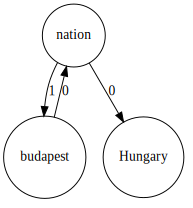

In [4]:
premise = text_to_4lang.process_text("Budapest is a nation in Hungary", expand=True, depth=1, blacklist=["in", "on", "of"])
dot_graph_premise = premise.to_dot()
Source(dot_graph_premise)

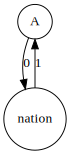

In [7]:
premise = text_to_4lang.process_deps(data_frame.iloc[0].premise, expand=True, depth=1)
dot_graph_premise = premise.to_dot()
Source(dot_graph_premise)

In [12]:
preds = []
for i in tqdm(range(len(data_frame))):
    index = i
    premise = data_frame.premise[index]
    hypothesis = data_frame.hypothesis[index]
    score = data_frame.score[index]
    graph_premise = text_to_4lang.process_text(premise, expand=True, depth=3, blacklist=["in", "on", "of"])
    graph_hypothesis = text_to_4lang.process_text(hypothesis, expand=True, depth=1, blacklist=["in", "on", "of"])
    pred = similarity.asim_jac_nodes(graph_premise, graph_hypothesis)
    if pred > 0.2:
        preds.append(1)
    else:
        preds.append(0)

100%|██████████| 996/996 [05:40<00:00,  3.47it/s]


In [ ]:
scores = 

In [13]:
from sklearn.metrics import precision_recall_fscore_support as pr
bPrecis, bRecall, bFscore, bSupport = pr(data_frame.score.tolist(), preds, average='binary')

print("Precision: " +  str(bPrecis))
print("Recall: " +  str(bRecall))
print("Fscore: " +  str(bFscore))

Precision: 0.45491803278688525
Recall: 0.33534743202416917
Fscore: 0.38608695652173913
